## note on 2020.1.14
- compare restored data with original data, found data folding back issue
- count rain coverage through the whole year, 
- **output: rain_coverage_2019.joblib**

In [1]:
import glob
import numpy as np
from datetime import datetime,timedelta
import calendar
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import joblib
%matplotlib inline
import os
print(os.getcwd())

/Users/jiang/github_all/rainymotion/docs/notebooks


## one day test

In [57]:
#data_folder = "/Volumes/own4T/jma_radar_401300210"
data_folder = "/Users/jiang/data/jma_radar"
dt    = datetime(2020,1,7,0,0)  # included
input_file  = f"jma_radar_uint8_{dt.strftime('%Y_%m_%d')}.joblib"
input_path = os.path.join(data_folder, input_file)
#joblib.dump(monthly_data[(day-1)*288 : day*288], output_path)
data = joblib.load(input_path)

In [77]:
%%time
rain_coverage = []
for i in range(data.shape[0]):
    each = data[i,:,:]
    rainy_pixels = np.sum(each >= 1)
    rain_coverage.append(rainy_pixels/( 1e6 - 132396)*100)

CPU times: user 213 ms, sys: 13.9 ms, total: 227 ms
Wall time: 226 ms


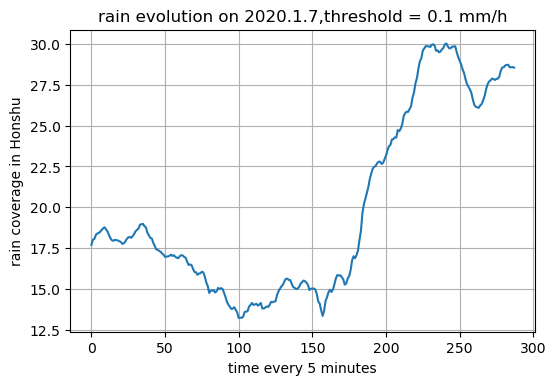

In [67]:
plt.figure(dpi=100)
plt.plot(rain_coverage)
plt.xlabel("time every 5 minutes")
plt.ylabel("rain coverage in Honshu")
plt.title(f"rain evolution on 2020.1.7,threshold = 0.1 mm/h")
plt.grid()
plt.show()

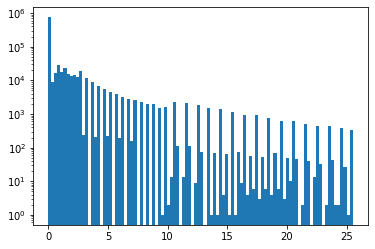

In [64]:
plt.hist((data[-1].astype('float32')/10).flatten(),100)
plt.yscale('log')
plt.show()

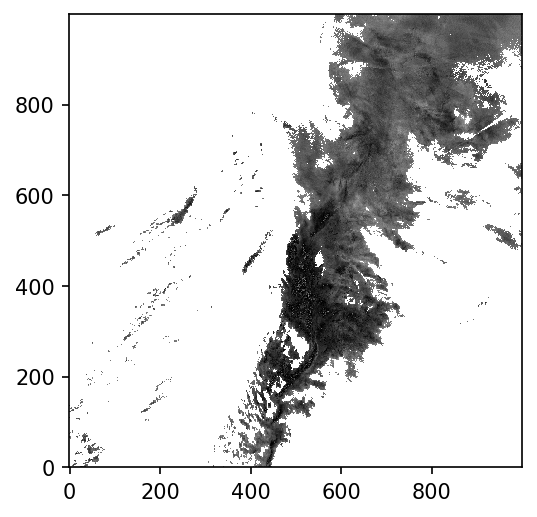

In [61]:
plt.figure(dpi=150)
plt.imshow(np.log(data[-1].astype('float32')/10+0.01), cmap = "gray_r",origin = "lower")
plt.show()

## one year 2019, count rain coverage by every 5 minutes
- build a 2D array, shape(365, 288)

In [115]:
%%time
rain_year = np.zeros(shape=(365,288), dtype = np.float16)
data_folder = "/Users/jiang/data/jma_radar"
dt     = datetime(2019,1,1,0,0)  # included
dt_end = datetime(2020,1,1,0,0)  # not included
time_step = 24 * 60 * 60 # seconds
threshold = 0.1
cnt = 0 
while dt < dt_end:
    yday = dt.timetuple().tm_yday
    data_file  = f"jma_radar_uint8_{dt.strftime('%Y_%m_%d')}.joblib"
    full_path = os.path.join(data_folder, data_file)
    data = joblib.load(full_path)
    for i in range(data.shape[0]):
        each = data[i,:,:]
        rainy_pixels = np.sum(each >= threshold*10)  # because data has been amplified by 10 times
        rain_year[yday-1, i] = rainy_pixels/(1e6 - 132396)*100
    dt += timedelta(seconds = time_step)
    cnt += 1
    if cnt % 30 == 0:
        print(dt)

2019-01-31 00:00:00
2019-03-02 00:00:00
2019-04-01 00:00:00
2019-05-01 00:00:00
2019-05-31 00:00:00
2019-06-30 00:00:00
2019-07-30 00:00:00
2019-08-29 00:00:00
2019-09-28 00:00:00
2019-10-28 00:00:00
2019-11-27 00:00:00
2019-12-27 00:00:00
CPU times: user 2min 32s, sys: 46.3 s, total: 3min 18s
Wall time: 3min 20s


### which hour has more rain? 
- evening has slightly more rain

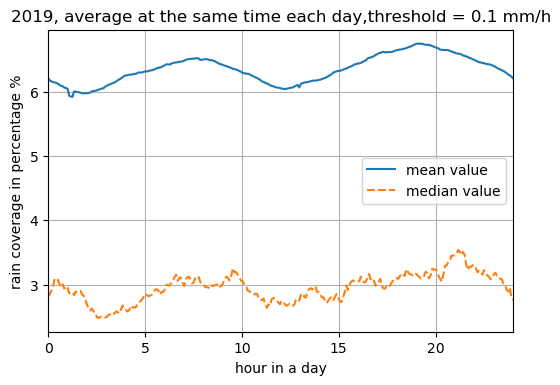

In [27]:
plt.figure(dpi=100)
plt.plot(np.linspace(0,24,288),np.mean(rain_year,axis=0),'-', label = "mean value")
plt.plot(np.linspace(0,24,288),np.median(rain_year,axis=0),'--',label = "median value")
plt.legend()
plt.xlabel("hour in a day")
plt.ylabel("rain coverage in percentage %")
plt.xlim([0,24])
plt.title(f"2019, average at the same time each day,threshold = 0.1 mm/h")
plt.grid()
plt.show()

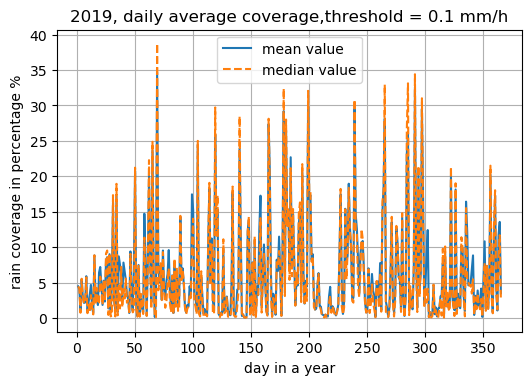

In [29]:
plt.figure(dpi=100)
plt.plot(np.linspace(1,365,365),np.mean(rain_year,axis=1),'-', label = "mean value")
plt.plot(np.linspace(1,365,365),np.median(rain_year,axis=1),'--',label = "median value")
plt.legend()
plt.xlabel("day in a year")
plt.ylabel("rain coverage in percentage %")
plt.title(f"2019, daily average coverage,threshold = 0.1 mm/h")
plt.grid()
plt.show()

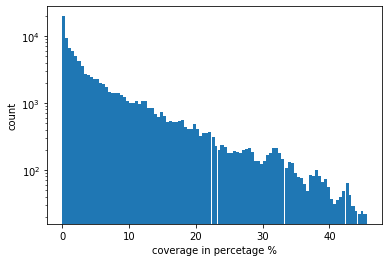

In [30]:
plt.hist(rain_year.flatten(),100)
plt.yscale('log')
plt.ylabel("count")
plt.xlabel("coverage in percetage %")
plt.show()

In [155]:
data_folder = "/Users/jiang/data/jma_radar"
output_file  = f"rain_coverage_2019.joblib"
output_path = os.path.join(data_folder, output_file)
joblib.dump(rain_year, output_path)

['/Users/jiang/data/jma_radar/rain_coverage_2019.joblib']

## select data for testing
build 2 datasets:
1. coverage >= 10%, continue for 1 hour
2. coverage >= 20%, continue for 1 hour

conclusion: it doesn't really matter it continues or not, because the large scale rain never suddenly stops, it gradually decays

In [ ]:
import joblib

In [175]:
%%time
tot = 365*288 # 105120
rain_year1D = rain_year.flatten()
larger10_first= rain_year1D >= 10
larger20_first= rain_year1D >= 20
print(np.sum(larger10_first),np.sum(larger20_first))

23508 8066
CPU times: user 174 ms, sys: 901 µs, total: 174 ms
Wall time: 174 ms


In [178]:
larger10_continue = np.full(shape = (tot,), fill_value = False, dtype = bool)
larger20_continue = np.full(shape = (tot,), fill_value = False, dtype = bool)
for i in range(tot-12):
    if larger10_first[i] and larger10_first[i+12]:
        larger10_continue[i] = True
        if larger20_first[i] and larger20_first[i+12]:
            larger20_continue[i] = True
print(np.sum(larger10_continue),np.sum(larger20_continue))            

22110 7394


In [193]:
output_file  = f"rain_continue_collection.joblib"
output_path = os.path.join(data_folder, output_file)
joblib.dump((larger10_first, larger20_first, larger10_continue,larger20_continue), output_path)

['/Users/jiang/data/jma_radar/rain_continue_collection.joblib']

## whether every day has rain?
- 168 days

In [3]:
data_folder = "/Users/jiang/data/jma_radar"
output_file  = f"rain_coverage_2019.joblib"
output_path = os.path.join(data_folder, output_file)
rain_year = joblib.load(output_path)
rain_year.shape

(365, 288)

In [32]:
max_each_day = np.max(rain_year, axis=1)
total_rainy_day = np.sum(max_each_day >=10) # 168
each_rainy_day = np.sum(rain_year >= 10, axis = 1)

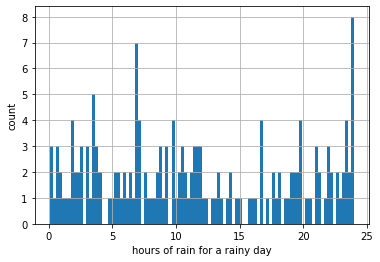

10.541666666666668


In [46]:
import seaborn as sns
plt.hist(each_rainy_day[each_rainy_day>0]/12,100)
plt.xlabel("hours of rain for a rainy day")
plt.ylabel("count")
plt.grid()
plt.show()
print(np.median(each_rainy_day[each_rainy_day>0]/12))

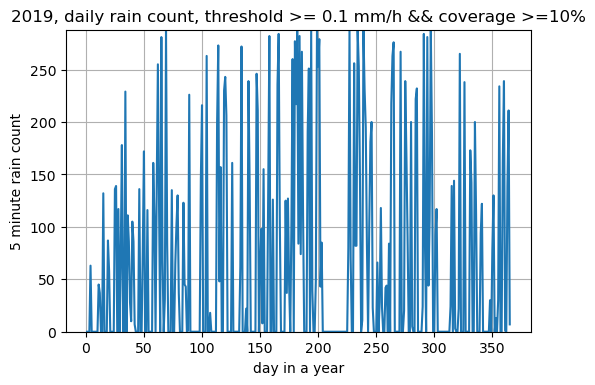

In [19]:
plt.figure(dpi=100)
plt.plot(list(range(1,366)),np.sum(rain_year >= 10, axis = 1),'-')
plt.xlabel("day in a year")
plt.ylabel("5 minute rain count")
plt.title(f"2019, daily rain count, threshold >= 0.1 mm/h && coverage >=10%")
plt.ylim([0,288])
plt.grid()
plt.show()

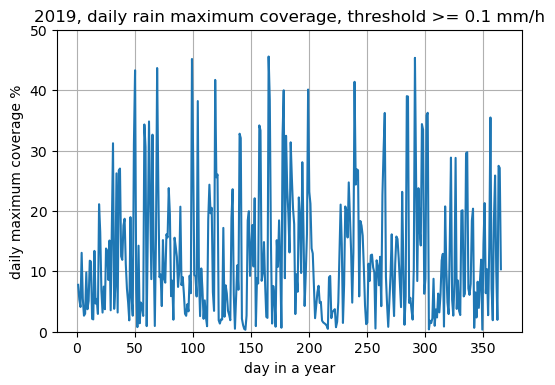

In [26]:
plt.figure(dpi=100)
plt.plot(list(range(1,366)),max_each_day,'-')
plt.xlabel("day in a year")
plt.ylabel("daily maximum coverage %")
plt.title(f"2019, daily rain maximum coverage, threshold >= 0.1 mm/h")
plt.ylim([0,50])
plt.grid()
plt.show()

## test 2020 rain coverage

In [3]:
rain_year = np.zeros(shape=(23,288), dtype = np.float16)
data_folder = "/Users/jiang/data/jma_radar"
dt     = datetime(2020,1,1,0,0)  # included
dt_end = datetime(2020,1,24,0,0)  # not included
time_step = 24 * 60 * 60 # seconds
threshold = 0.1
cnt = 0 
while dt < dt_end:
    yday = dt.timetuple().tm_yday
    data_file  = f"jma_radar_uint8_{dt.strftime('%Y_%m_%d')}.joblib"
    full_path = os.path.join(data_folder, data_file)
    data = joblib.load(full_path)
    for i in range(data.shape[0]):
        each = data[i,:,:]
        rainy_pixels = np.sum(each >= threshold*10)  # because data has been amplified by 10 times
        rain_year[yday-1, i] = rainy_pixels/(1e6 - 132396)*100
    dt += timedelta(seconds = time_step)
    cnt += 1
    if cnt % 30 == 0:
        print(dt)

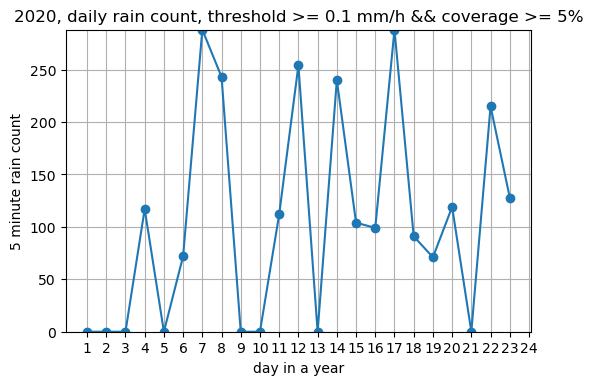

In [8]:
plt.figure(dpi=100)
plt.plot(list(range(1,24)),np.sum(rain_year >= 5, axis = 1),'-o')
plt.xlabel("day in a year")
plt.ylabel("5 minute rain count")
plt.title(f"2020, daily rain count, threshold >= 0.1 mm/h && coverage >= 5%")
plt.xticks(np.linspace(1,24,24))
plt.ylim([0,288])
plt.grid()
plt.show()